<a href="https://colab.research.google.com/github/MasoudMoeini/Google-Street-View-Images-Blur-Detection/blob/main/SVIB_dataset_generating_with_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download and unzip data from dataset

In [ ]:
!wget http://www.cs.ucf.edu/~aroshan/index_files/Dataset_PitOrlManh/zipped%20images/part1.zip


--2022-10-19 10:51:48--  http://www.cs.ucf.edu/~aroshan/index_files/Dataset_PitOrlManh/zipped%20images/part1.zip
Resolving www.cs.ucf.edu (www.cs.ucf.edu)... 132.170.216.243
Connecting to www.cs.ucf.edu (www.cs.ucf.edu)|132.170.216.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4902098439 (4.6G) [application/zip]
Saving to: ‘part1.zip’

part1.zip           100%[===================>]   4.57G  11.6MB/s    in 6m 59s  

2022-10-19 10:58:47 (11.2 MB/s) - ‘part1.zip’ saved [4902098439/4902098439]



# Before starting dataset generation upload manually cars.xml file 

In [ ]:
!unzip -q part1.zip -d  part1 

In [ ]:
from PIL import Image, ImageFilter
import glob
import os
import numpy as np
import cv2
from random import *
import shutil

In [ ]:
train_image_path='images'
train_label_path = 'labels'
folder= 'part1'

In [ ]:
def cars_detection(image_name):
  image = Image.open(image_name)
  image = image.resize((900,500))
  image_arr = np.array(image)
  grey = cv2.cvtColor(image_arr,cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(grey,(5,5),0)
  dilated = cv2.dilate(blur,np.ones((3,3)))
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
  closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)
  closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel) 
  car_cascade_src = 'cars.xml'
  car_cascade = cv2.CascadeClassifier(car_cascade_src)
  cars = car_cascade.detectMultiScale(closing, scaleFactor=1.1, minNeighbors=5, minSize=(90,90)) 
  return cars

In [ ]:
def roi_blurring(image_name,cars):
  img = cv2.imread(image_name)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(900,500))
  #(x,y,w,h) [551, 288, 103, 103]
  #label for blureed image 
  label_img = Image.fromarray(np.zeros((500, 900, 3), dtype = "uint8"))
  final_image=Image.fromarray(img)
  for i in range(cars.shape[0]):
    cropped_image = img[cars[i][1]:cars[i][1]+cars[i][3],cars[i][0]:cars[i][0]+cars[i][2]]
    blurred_image = Image.fromarray(cropped_image).filter(ImageFilter.GaussianBlur(15))
    final_image.paste(blurred_image, (cars[i][0], cars[i][1]))
    whiteFrame = Image.fromarray(255 * np.ones((cars[i][3],cars[i][2],3), np.uint8))
    #img.paste(cropped,(x,y))
    label_img.paste(whiteFrame, (cars[i][0], cars[i][1]))
  return final_image,label_img

In [ ]:
def blurizing_creating_blur_label(train_image_path,train_label_path,filename):
    cars = cars_detection(filename)
    if cars!=():
      final_image,label_img = roi_blurring(filename,cars)
      final_image = final_image.resize((224,224))
      final_image.save(train_image_path+'/'+'0-'+os.path.split(filename)[1])
      label_img = label_img.resize((224,224))
      label_img.save(train_label_path+'/'+'0-'+os.path.split(filename)[1])
    else:
      image_blur =Image.open(filename)
      img = cv2.imread(filename)
      width, height = image_blur.size
      dic ={'1':{'h1':int( height / 4),'h2':800,'w1':900,'w2':1200,'left':900},
            '2':{'h1':int( height / 3),'h2':600,'w1':100,'w2':600,'left':100},
            '3':{'h1':int( height / 4),'h2':700,'w1':500,'w2':1000,'left':500},
            '4':{'h1':int( height / 4),'h2':700,'w1':700,'w2':1100,'left':700},
            '5':{'h1':int( height / 4),'h2':1000,'w1':100,'w2':600,'left':100},
            '6':{'h1':int(2* height / 4),'h2':1000,'w1':100,'w2':600,'left':100},
            '7':{'h1':int(height / 4),'h2':900,'w1':100,'w2':500,'left':100},
            '8':{'h1':int(height / 5),'h2':800,'w1':700,'w2':1100,'left':700}}
      # Cropping an image
      x = randint(1,8)
      cropped_image = img[dic[str(x)]['h1']:dic[str(x)]['h2'], dic[str(x)]['w1']:dic[str(x)]['w2']]
      cropped_image=cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
      blurred_image = Image.fromarray(cropped_image).filter(ImageFilter.GaussianBlur(20))
      blurred_image = blurred_image.filter(ImageFilter.GaussianBlur(20)) 
      image_blur.paste(blurred_image, (dic[str(x)]['left'], dic[str(x)]['h1']))
      image_blur = image_blur.resize((224,224))
      #image_blur.save(blur_path+'/'+ os.path.split(filename)[1])
      image_blur.save(train_image_path+'/'+'0-'+os.path.split(filename)[1])
      #image_blur.save('{}{}{}'.format(blur_path,'/',os.path.split(filename)[1]))
      #label for blureed image 
      label_img = np.zeros((height, width, 3), dtype = "uint8")
      label_img = Image.fromarray(label_img)
      w,h = Image.fromarray(cropped_image).size
      whiteFrame = 255 * np.ones((h,w,3), np.uint8)
      whiteFrame = Image.fromarray(whiteFrame)
      #img.paste(cropped,(x,y))
      label_img.paste(whiteFrame,(dic[str(x)]['left'], dic[str(x)]['h1']))
      label_img = label_img.resize((224,224))
      #label_img.save('{}{}{}'.format(blur_label_path,'/',os.path.split(filename)[1]))
      label_img.save(train_label_path+'/'+'0-'+os.path.split(filename)[1])
      #label_img.save('{}{}{}'.format(train_label_path,'/','0-',os.path.split(filename)[1]))
    

In [ ]:
def resize_images_creating_label(train_image_path,train_label_path,folder):
    temp = 'temp'
    if not os.path.exists(temp):
        os.makedirs(temp)
    if not os.path.exists(train_image_path):
        os.makedirs(train_image_path)
    if not os.path.exists(train_label_path):
        os.makedirs(train_label_path)
    #starting processing images
    images_list=os.listdir(folder)
    i=0
    for item in images_list[:5000]: #which images
        image = Image.open(folder+"/"+item)   
        image.save(temp +'/' + str(i)+'.jpg', 'JPEG', quality=90) 
        i+=1
    for filename in glob.glob(temp+'/' +'*.jpg'): #path of raw images
        blurizing_creating_blur_label(train_image_path,train_label_path,filename)
        image = Image.open(filename)
        width, height = image.size
        image = image.resize((224,224))
        # save resized images to new folder with existing filename
        #image.save('{}{}{}'.format(no_blur_path,'/',os.path.split(filename)[1]))
        image.save(train_image_path+'/'+'1-'+os.path.split(filename)[1])
        label_img = np.zeros((height, width, 3), dtype = "uint8")
        label_img = Image.fromarray(label_img)
        label_img = label_img.resize((224,224))
        #label_img.save('{}{}{}'.format(no_blur_label_path,'/',os.path.split(filename)[1]))
        label_img.save(train_label_path+'/'+'1-'+os.path.split(filename)[1])
        
    shutil.rmtree(temp)
    
    

# Applying GaussainBlur filter , resizing images , generating grund-truth label for images 

In [ ]:
resize_images_creating_label(train_image_path,train_label_path,folder)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
from PIL import Image
from numpy import *
images = []
labels= []
files = glob.glob ("images/*.jpg")
for myFile in files:
    image = array(Image.open(myFile))
    images.append(image)
    image_name=os.path.split(myFile)[1] #1-365.jpg
    label=array(Image.open("labels/"+image_name))
    labels.append(label)

In [ ]:
len(images)

10000

In [ ]:
len(labels)

10000

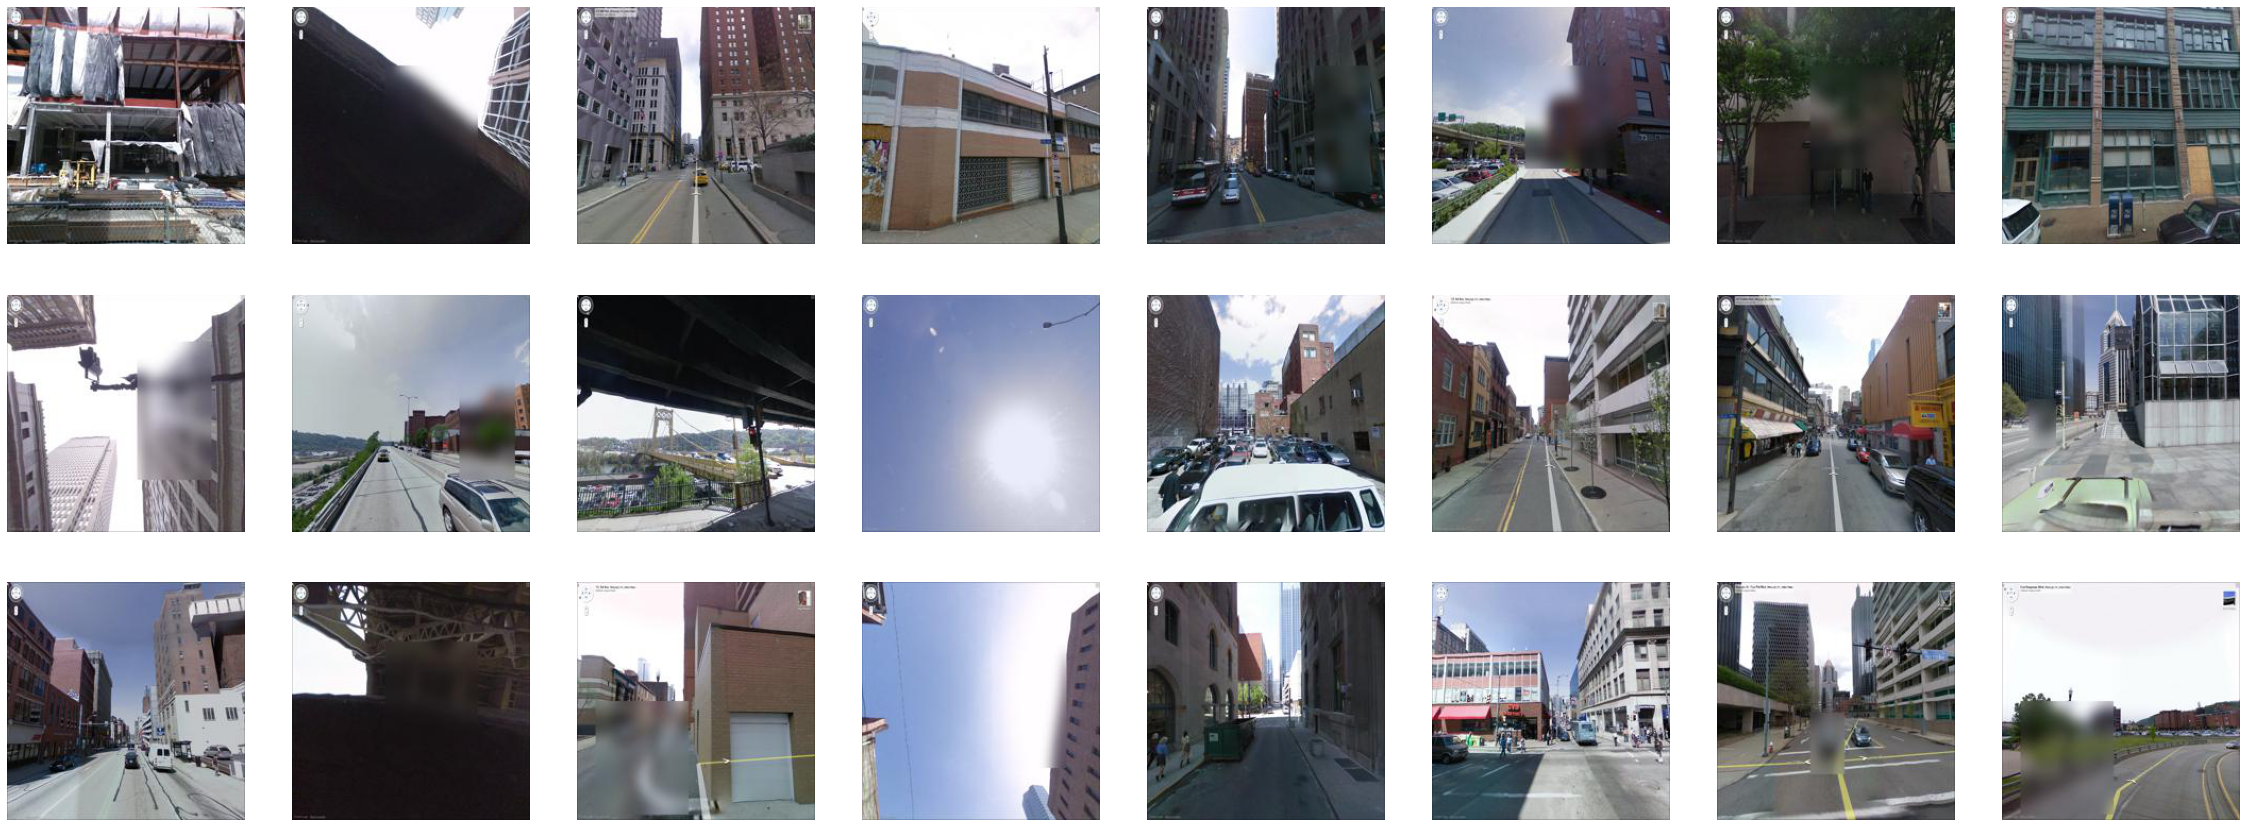

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(40, 15))
columns = 8
rows = 3
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns,i+1)
    plt.imshow(images[i],cmap='binary')
    plt.axis("off")
plt.show()

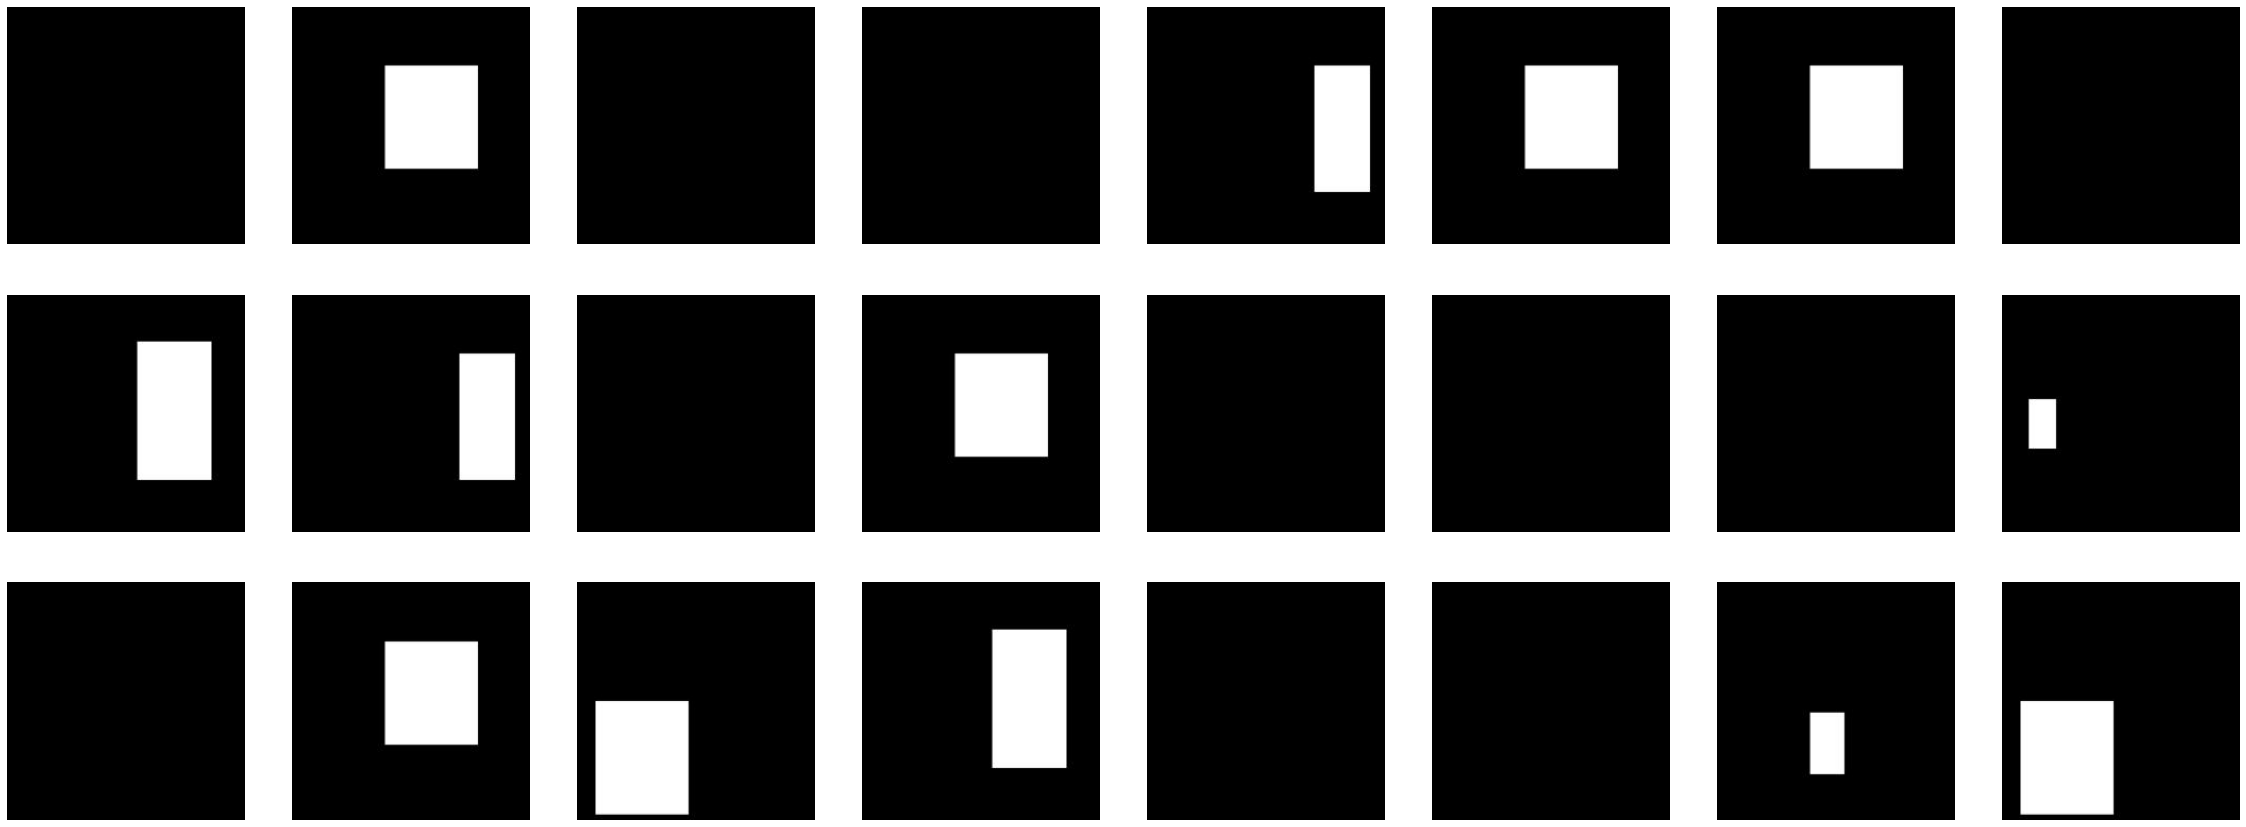

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(40, 15))
columns = 8
rows = 3
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns,i+1)
    plt.imshow(labels[i],cmap='binary')
    plt.axis("off")
plt.show()

In [ ]:
!zip -q -r images.zip images

In [ ]:
!zip -q -r labels.zip labels

# Download images.zip and labels.zip files